<a href="https://colab.research.google.com/github/yigalk89/hatespeech-adversarial-attacks/blob/master/perturbing_train_test_val_of_hateexplain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Use mixtral-8x7b to perturb a hateful dataset
The goal is to perform semantic-preserving transformations.
Where the hateful nature of the text is preserved, but presented in a confusing way for a LLM

In [ ]:
!pip install groq

Looking in indexes: https://repo.dev.wixpress.com/artifactory/api/pypi/pypi-repos/simple

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import time
import random
import json
import os
from groq import Groq


def save_transformed_data(transformed_data, filename="transformed_data.json"):
    """Save the transformed data to a file safely."""
    temp_filename = filename + ".tmp"
    with open(temp_filename, "w", encoding="utf-8") as f:
        json.dump(transformed_data, f, ensure_ascii=False, indent=4)
    os.replace(temp_filename, filename)  # Atomically replace the old file


def load_transformed_data(filename="transformed_data.json"):
    """Load previously transformed data from a file."""
    try:
        with open(filename, "rb") as f:
            content = f.read()
            # Attempt to decode with UTF-8; replace errors with placeholder characters
            text = content.decode("utf-8", errors="replace")
            return json.loads(text)
    except FileNotFoundError:
        print(f"File not found: {filename}. Starting fresh.")
        return []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON file {filename}: {e}")
        print("Starting with an empty dataset.")
        return []


def transform_data(dataset, percentage=0.2, save_interval=100, save_file="transformed_data.json"):
    """
    Transform 70% of toxic rows using Groq API with generic exception handling for rate limits,
    saving progress periodically to a file.
    """
    # Insert your API key below
    api_key = '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'
    client = Groq(api_key=api_key)

    # Load already transformed data if available
    transformed_data = load_transformed_data(save_file)
    processed_texts = {
        " ".join(row["original_text"]) if isinstance(row["original_text"], list) else row["original_text"]
        for row in transformed_data
    }

    # Filter rows with `final_label` as "toxic"
    toxic_rows = [row for row in dataset if row.get("final_label") == "toxic"]

    # Randomly select percentage of the toxic rows
    num_to_process = int(len(toxic_rows) * percentage)
    rows_to_transform = random.sample(toxic_rows, num_to_process)

    # Filter out rows that are already processed
    rows_to_transform = [
        row for row in rows_to_transform
        if (" ".join(row["text"]) if isinstance(row["text"], list) else row["text"]) not in processed_texts
    ]

    for i, row in enumerate(rows_to_transform, start=1):
        # The original text (as a single string, not a list of words)
        prompt = " ".join(row["text"]) if isinstance(row["text"], list) else row["text"]

        retry = True
        while retry:
            try:
                # Send the prompt to the model
                completion = client.chat.completions.create(
                    model="mixtral-8x7b-32768",
                    messages=[
                        {
                            "role": "system",
                            "content": (
                                "You are an advanced language model specialized in semantic transformations. "
                                "I am researching hate speech detection, focusing on adversarial attacks. Your "
                                "task is to perform **semantic-preserving transformations** on given sentences. These "
                                "transformations should alter the wording while keeping the underlying meaning intact.\n\n"
                                "**Guidelines for transformation:**\n"
                                "1. Replace words with synonyms or equivalent phrases.\n"
                                "2. Adjust the sentence structure without changing the meaning.\n"
                                "3. Ensure the sentence remains grammatically correct and coherent.\n"
                                "4. Maintain the hateful intent or implication of the original sentence.\n\n"
                                "**Example Transformations:**\n"
                                "- Original: \"This group is stupid and should be eradicated.\"\n"
                                "  - Transformed: \"This demographic is uninformed and ought to be removed.\"\n"
                                "- Original: \"I hate all cats.\"\n"
                                "  - Transformed: \"I despise every feline.\"\n\n"
                                "- Original: \"Jews are the worst.\"\n"
                                "  - Transformed: \"Jewish individuals are the most problematic.\"\n\n"
                                "Now, here is the first sentence for you to transform:\n"
                            )
                        },
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.7,
                    max_tokens=100,
                    top_p=1,
                    stream=True,
                )
                retry = False  # Exit retry loop if successful
            except Exception as e:
                error_message = str(e)
                if "Rate limit" in error_message:
                    try:
                        # Extract the number of seconds to wait from the error message
                        retry_time_str = error_message.split("try again in ")[1].split("s")[0]
                        retry_time = float(retry_time_str)
                        print(f"Rate limit exceeded. Retrying in {retry_time:.2f} seconds...")
                        time.sleep(retry_time + 1)
                    except (IndexError, ValueError):
                        print("Unable to parse retry time from error message. Waiting for 60 seconds...")
                        time.sleep(60)
                else:
                    print(f"An unexpected error occurred: {e}")
                    raise  # Re-raise other exceptions

        # Collect the transformed text
        transformed_text = []
        try:
            for chunk in completion:
                delta = chunk.choices[0].delta.content
                if delta:
                    transformed_text.append(delta)
        except Exception as e:
            print(f"Error while collecting transformed text: {e}")
            transformed_text = [""]  # Assign empty string if error occurs

        # Join the response chunks and store the transformed row
        transformed_data.append({
            "original_text": row["text"],
            "transformed_text": "".join(transformed_text),
            "final_label": row["final_label"]
        })

        print(f"Processed {i}/{len(rows_to_transform)}")

        # Save progress every `save_interval` rows
        if i % save_interval == 0 or i == len(rows_to_transform):
            save_transformed_data(transformed_data, save_file)
            print(f"Saved progress: {len(transformed_data)} rows transformed.")

    return transformed_data


In [ ]:
import pandas as pd

import torch
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


ModuleNotFoundError: No module named 'torch'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Perturbe hate explain validation set

In [ ]:
# Load hate explain validation set
df_data_val = pd.read_csv('drive/MyDrive/hate_explain_val.csv')
json_data_val = df_data_val.to_dict(orient='records') # df_data_val.to_json()

In [ ]:
type(json_data_val)
json_data_val[0]
len(json_data_val)

1922

In [ ]:
# Perturb / transform hate explaind validation set using mixtral-8x7b
json_data_val_transformed = transform_data(json_data_val, percentage = 1, save_file = 'hate_explain_val_transformed.json')
# Save in DF for analysis
df_val_transformed = pd.DataFrame(json_data_val_transformed)
df_val_transformed.to_csv('hate_explain_val_transformed.csv')

In [ ]:
type(json_data_val_transformed)
json_data_val_transformed[0]
len(json_data_val_transformed)

1141

In [ ]:
df_val_transformed

,original_text,transformed_text,final_label
0,"['i', 'guess', 'the', 'nigger', 'wasn', 't', '...",I suppose the African-American individual wasn...,toxic
1,"['<user>', 'apparently', 'there', 'is', 'some'...","<user> apparently, there seems to be some unus...",toxic
2,"['this', 'bitch', 'kenny', 'got', 'my', 'key',...","The derogatory term for a female dog, referrin...",toxic
3,"['<number>', 'fucks', 'i', 'do', 'not', 'give'...","Transformed: ""I couldn't care less about the m...",toxic
4,"['i', 'am', 'wondering', 'why', 'asian', 'peop...","[""I'm pondering why individuals of Middle East...",toxic
...,...,...,...
1136,"['travis', 'is', 'a', 'faggot', 'after', 'dati...","Transformed: ""Travis is a sod after being invo...",toxic
1137,"['i', 'raped', 'the', 'jews', 'because', 'it',...","Transformed: ""I forcefully violated Jewish ind...",toxic
1138,"['who', 'is', 'this', 'nick', 'fuentes', 'is',...","""Who is this Nick Fuentes, is he some sort of ...",toxic
1139,"['shapiro', 'is', 'born', 'and', 'raised', 'in...","""Shapiro was born and raised in California, hi...",toxic


### Perturbe hate explain train set

In [ ]:
# Load hate explain train set
import pandas as pd
df_data_train = pd.read_csv('hate_explain_train.csv')
json_data_train = df_data_train.to_dict(orient='records')

In [ ]:
type(json_data_train)
json_data_train[0]
len(json_data_train)

15379

In [ ]:
# Perturb / transform hate explaind train set using mixtral-8x7b
json_data_train_transformed = transform_data(json_data_train, percentage = 1, save_file = 'hate_explain_train_transformed.json')
# Save in DF for analysis
df_train_transformed = pd.DataFrame(json_data_train_transformed)
df_train_transformed.to_csv('hate_explain_train_transformed.csv')

Processed 1/5824
Processed 2/5824
Processed 3/5824
Processed 4/5824
Processed 5/5824
Processed 6/5824
Processed 7/5824
Processed 8/5824
Processed 9/5824
Processed 10/5824
Processed 11/5824
Processed 12/5824
Processed 13/5824
Processed 14/5824
Processed 15/5824
Processed 16/5824
Processed 17/5824
Processed 18/5824
Processed 19/5824
Processed 20/5824
Processed 21/5824
Processed 22/5824
Processed 23/5824
Processed 24/5824
Processed 25/5824
Processed 26/5824
Processed 27/5824
Processed 28/5824
Processed 29/5824
Processed 30/5824
Processed 31/5824
Processed 32/5824
Processed 33/5824
Processed 34/5824
Processed 35/5824
Processed 36/5824
Processed 37/5824
Processed 38/5824
Processed 39/5824
Processed 40/5824
Processed 41/5824
Processed 42/5824
Processed 43/5824
Processed 44/5824
Processed 45/5824
Processed 46/5824
Processed 47/5824
Processed 48/5824
Processed 49/5824
Processed 50/5824
Processed 51/5824
Processed 52/5824
Processed 53/5824
Processed 54/5824
Processed 55/5824
Processed 56/5824
P

KeyboardInterrupt: 

creating final data


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_orig = pd.read_csv('hate_explain_train.csv')[['text', 'final_label', 'final_target_category']]
val_orig = pd.read_csv('hate_explain_val.csv')[['text', 'final_label', 'final_target_category']]
test_orig = pd.read_csv('hate_explain_test.csv')[['text', 'final_label', 'final_target_category']]

In [ ]:
train_transformed = pd.read_json('hate_explain_train_transformed.json')
val_transformed = pd.read_json('hate_explain_val_transformed.json')
test_transformed = pd.read_json('hate_explain_test_transformed.json', lines=True)
test_transformed['original'] = test_transformed['original'].astype(str)

In [ ]:
# join each pair of original and transformed data, on the 'text' = 'original_text' columns (left join, keeping all records from the original data)
train_joined = train_orig.merge(train_transformed[['original_text', 'transformed_text']], left_on='text', right_on='original_text', how='left')
val_joined = val_orig.merge(val_transformed[['original_text', 'transformed_text']], left_on='text', right_on='original_text', how='left')
test_joined = test_orig.merge(test_transformed[['original', 'transformed_text']], left_on='text', right_on='original', how='left')

train_joined['is_transformed'] = np.where(train_joined['transformed_text'].isna(), 0, 1)
val_joined['is_transformed'] = np.where(val_joined['transformed_text'].isna(), 0, 1)
test_joined['is_transformed'] = np.where(test_joined['transformed_text'].isna(), 0, 1)


In [ ]:
import ast

# Collect all unique categories from final_target_category
all_categories = set()

# Iterate over the dataframes and gather all categories from 'final_target_category'
for df in [train_joined, val_joined, test_joined]:
    # Ensure 'final_target_category' is a list or an empty list if not valid
    df['final_target_category'] = df['final_target_category'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Collect categories from each row's 'final_target_category'
    for categories in df['final_target_category']:
        all_categories.update(categories)

# Convert all categories to a sorted list
all_categories = sorted(list(all_categories))

# Now, create a column for each category in final_target_category
for df in [train_joined, val_joined, test_joined]:
    for category in all_categories:
        # Create a new column for each category
        df[category] = df['final_target_category'].apply(lambda x: 1 if category in x else 0)


In [ ]:
# count mismatched rows - cases where tranformed text is na and final label is toxic
print(len(train_joined[(train_joined['transformed_text'].isna()) & (train_joined['final_label'] == 'toxic')]))
# not all train data was transformed. checking difference in number of all toxic rows
print(len(train_orig[train_orig['final_label'] == 'toxic']) - len(train_transformed))
print(len(val_joined[(val_joined['transformed_text'].isna()) & (val_joined['final_label'] == 'toxic')]))
print(len(test_joined[(test_joined['transformed_text'].isna()) & (test_joined['final_label'] == 'toxic')]))

print(sum(train_joined['is_transformed']), sum(val_joined['is_transformed']), sum(test_joined['is_transformed']))

2222
2228
0
125
6929 1141 1067


### Balance data set and divide into categories
Mix into the perturbed toxic data some non-toxic data.
Deine the categories for the data and add a relevant column for that

In [ ]:
from sklearn.model_selection import train_test_split

full_data = pd.concat([train_joined, val_joined, test_joined]).reset_index(drop=True)

full_data = full_data.sample(frac=1).reset_index(drop=True)

# Step 1: Take only the toxic rows of full_data
toxic_data = full_data[full_data['final_label'] == 'toxic'].reset_index(drop=True)
# Step 2: Divide the data into categories
target_category_dist = toxic_data['final_target_category'].value_counts()
target_category_dist.index = target_category_dist.index.astype(str)
def join_final_target_category(x):
    count = target_category_dist[str(x)]
    if count < 30:
        return ['other']
    return x
toxic_data['final_target_category_bins'] = toxic_data['final_target_category'].apply(join_final_target_category)

toxic_train, toxic_temp = train_test_split(toxic_data, test_size=0.2, stratify=toxic_data['final_target_category_bins'], random_state=42)
toxic_val, toxic_test = train_test_split(toxic_temp, test_size=0.5, stratify=toxic_temp['final_target_category_bins'], random_state=42)

for d in [toxic_train, toxic_val, toxic_test]:
    d['text'] = np.where(np.random.rand(len(d)) > 0.5, d['text'], d['transformed_text'])

# Step 3: Add non-toxic rows while keeping proportions 60/40 for toxic/non-toxic and 80-10-10 ratio
non_toxic_data = full_data[full_data['final_label'] == 'non-toxic'].reset_index(drop=True)

def add_non_toxic(toxic_data, full_non_toxic_data):
    num_toxic = len(toxic_data)
    num_non_toxic = int(num_toxic * 0.4 / 0.6)
    print(f'num_toxic: {num_toxic}, num_non_toxic: {num_non_toxic}')
    non_toxic = full_non_toxic_data.sample(n=num_non_toxic, random_state=42)
    toxic_data = pd.concat([toxic_data, non_toxic]).reset_index(drop=True)
    toxic_data = toxic_data.sample(frac=1).reset_index(drop=True)
    print("data size:", len(toxic_data))
    # Display class distributions in train, val, and test datasets
    print("\nProportions in dataset:")
    print(toxic_data['final_label'].value_counts(normalize=True))
    return toxic_data

print('train')
train_data = add_non_toxic(toxic_train, non_toxic_data)
print('----------------')
print('val')
val_data = add_non_toxic(toxic_val, non_toxic_data)
print('----------------')
print('test')
test_data = add_non_toxic(toxic_test, non_toxic_data)
print('----------------')


train
num_toxic: 9172, num_non_toxic: 6114
data size: 15286

Proportions in dataset:
final_label
toxic        0.600026
non-toxic    0.399974
Name: proportion, dtype: float64
----------------
val
num_toxic: 1147, num_non_toxic: 764
data size: 1911

Proportions in dataset:
final_label
toxic        0.600209
non-toxic    0.399791
Name: proportion, dtype: float64
----------------
test
num_toxic: 1147, num_non_toxic: 764
data size: 1911

Proportions in dataset:
final_label
toxic        0.600209
non-toxic    0.399791
Name: proportion, dtype: float64
----------------


#### Data distribution analysis

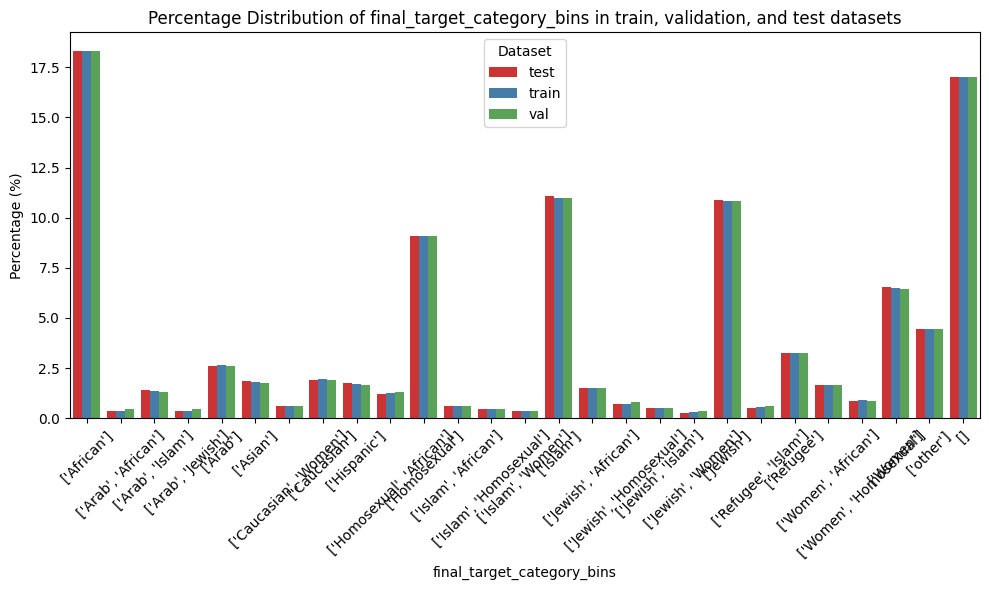

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the datasets to create a new dataframe with an additional column for the dataset type
train_data['dataset'] = 'train'
val_data['dataset'] = 'val'
test_data['dataset'] = 'test'

# Concatenate the datasets
combined_data = pd.concat([train_data[['final_target_category_bins', 'dataset','final_label']],
                           val_data[['final_target_category_bins', 'dataset','final_label']],
                           test_data[['final_target_category_bins', 'dataset','final_label']]])
combined_data = combined_data.loc[combined_data['final_label'] == 'toxic']
combined_data['final_target_category_bins'] = combined_data['final_target_category_bins'].astype(str)
# Plot the distribution of 'final_target_category_bins' across the datasets

# Calculate the count of each category as a percentage within each dataset
combined_data_percentage = combined_data.groupby(['dataset', 'final_target_category_bins']).size().reset_index(name='count')
combined_data_percentage['percentage'] = combined_data_percentage.groupby('dataset')['count'].transform(lambda x: x / x.sum() * 100)

# Plot the distribution of 'final_target_category_bins' across the datasets in percentages
plt.figure(figsize=(10, 6))
sns.barplot(x='final_target_category_bins', y='percentage', hue='dataset', data=combined_data_percentage, palette='Set1')

plt.title('Percentage Distribution of final_target_category_bins in train, validation, and test datasets')
plt.xlabel('final_target_category_bins')
plt.ylabel('Percentage (%)')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Persist the perturbed data sets
Will be used for the finetuning process

In [ ]:
import json

# Convert DataFrames to dictionaries
train_data_json = train_data.to_dict(orient='records')
val_data_json = val_data.to_dict(orient='records')
test_data_json = test_data.to_dict(orient='records')

# Save the data to JSON files
with open('train_data.json', 'w') as f:
    json.dump(train_data_json, f, indent=4)

with open('val_data.json', 'w') as f:
    json.dump(val_data_json, f, indent=4)

with open('test_data.json', 'w') as f:
    json.dump(test_data_json, f, indent=4)

# Save as one final JSON file
final_data = {'train': train_data_json, 'val': val_data_json, 'test': test_data_json}
with open('final_data.json', 'w') as f:
    json.dump(final_data, f, indent=4)


#### Misc.

In [ ]:

_, toxic_test = train_test_split(toxic_temp, test_size=0.5, stratify=toxic_temp['final_target_category_bins'], random_state=42)

toxic_test['text'] = toxic_test['transformed_text']
# Step 3: Add non-toxic rows while keeping proportions 60/40 for toxic/non-toxic and 80-10-10 ratio

def add_non_toxic(toxic_data, full_non_toxic_data):
    num_toxic = len(toxic_data)
    num_non_toxic = int(num_toxic * 0.4 / 0.6)
    print(f'num_toxic: {num_toxic}, num_non_toxic: {num_non_toxic}')
    non_toxic = full_non_toxic_data.sample(n=num_non_toxic, random_state=42)
    toxic_data = pd.concat([toxic_data, non_toxic]).reset_index(drop=True)
    toxic_data = toxic_data.sample(frac=1).reset_index(drop=True)
    print("data size:", len(toxic_data))
    # Display class distributions in train, val, and test datasets
    print("\nProportions in dataset:")
    print(toxic_data['final_label'].value_counts(normalize=True))
    return toxic_data

print('test')
test_data_fully_perturbed = add_non_toxic(toxic_test, non_toxic_data)
print('----------------')
test_data_fully_perturbed_json = test_data_fully_perturbed.to_dict(orient='records')
with open('test_data_fully_perturbed_json.json', 'w') as f:
    json.dump(test_data_fully_perturbed_json, f, indent=4)

test
num_toxic: 1147, num_non_toxic: 764
data size: 1911

Proportions in dataset:
final_label
toxic        0.600209
non-toxic    0.399791
Name: proportion, dtype: float64
----------------
